# DesicionTreeClassifier

Decision tree learners create biased trees if some classes dominate. It is therefore recommended to balance the dataset prior to fitting with the decision tree.

Decision-tree learners can create over-complex trees that do not generalise the data well. This is called overfitting. Mechanisms such as pruning, setting the minimum number of samples required at a leaf node or setting the maximum depth of the tree are necessary to avoid this problem.

Decision trees can be unstable because small variations in the data might result in a completely different tree being generated. This problem is mitigated by using decision trees within an ensemble.

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from mlscratchnk.supervised.decision_tree import DecisionTreeClassifier as CustomDecisionTreeClassifier
from mlscratchnk.supervised.gradient_boost import GradientBoostingClassifier
import mlscratchnk.supervised.decision_tree_visualizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def clean_target(target):
    target.loc[target == 'Male'] = 0
    target.loc[target == 'Female'] = 1
    return target.astype(int)

def get_splitted_data(nsamples=None, imbalanced_samples = None):
    data = pd.read_csv('weight-height.csv')
    data.columns = ['gender', 'height', 'weight']

    sub_data = data if nsamples is None else data.sample(nsamples, random_state=45)

    if imbalanced_samples is not None:
        female_sample = data[data['gender'] == 'Female'].sample(imbalanced_samples, random_state=1)
        sub_data = pd.concat([sub_data, female_sample])
        sub_data.drop_duplicates(inplace=True)
    

    features = sub_data.drop('gender', axis=1)
    target = clean_target(sub_data['gender'])

    #features_train, features_valid, target_train, target_valid 
    return train_test_split(features, target, test_size=0.25)

features_train, features_valid, target_train, target_valid = get_splitted_data(nsamples=1000)
features_train

,height,weight
985,66.473766,175.947368
772,69.145909,202.628196
9294,63.858324,136.852306
4553,69.672619,203.038218
4563,68.733514,186.992237
...,...,...
7913,66.709807,153.566607
2246,65.193988,156.286199
410,68.762458,196.293806
1018,66.997862,178.057336


In [4]:
color_classes = {0: 'blue', 1: 'red'}
label_classes = {0: 'Male', 1: 'Female'}
label_features = {0: 'height', 1: 'weight'}

def visualize_tree(model):
    return decision_tree_visualizer.visualize_result(model.root_node, color_classes, label_classes, label_features, save_pdf=False)


def test_model(model):
    predicted_train = model.predict(features_train.values)
    predicted = model.predict(features_valid.values)
    depth = model.get_depth() if hasattr(model, 'get_depth') else None
    print(f'train score = {f1_score(target_train.values, predicted_train):.3f}, valid score f1 = {f1_score(target_valid.values, predicted):.3f}, depth {depth}, name {model.__class__.__name__}')

train score = 0.924, valid score f1 = 0.919, depth 10, name DecisionTreeClassifier
Wall time: 23 ms


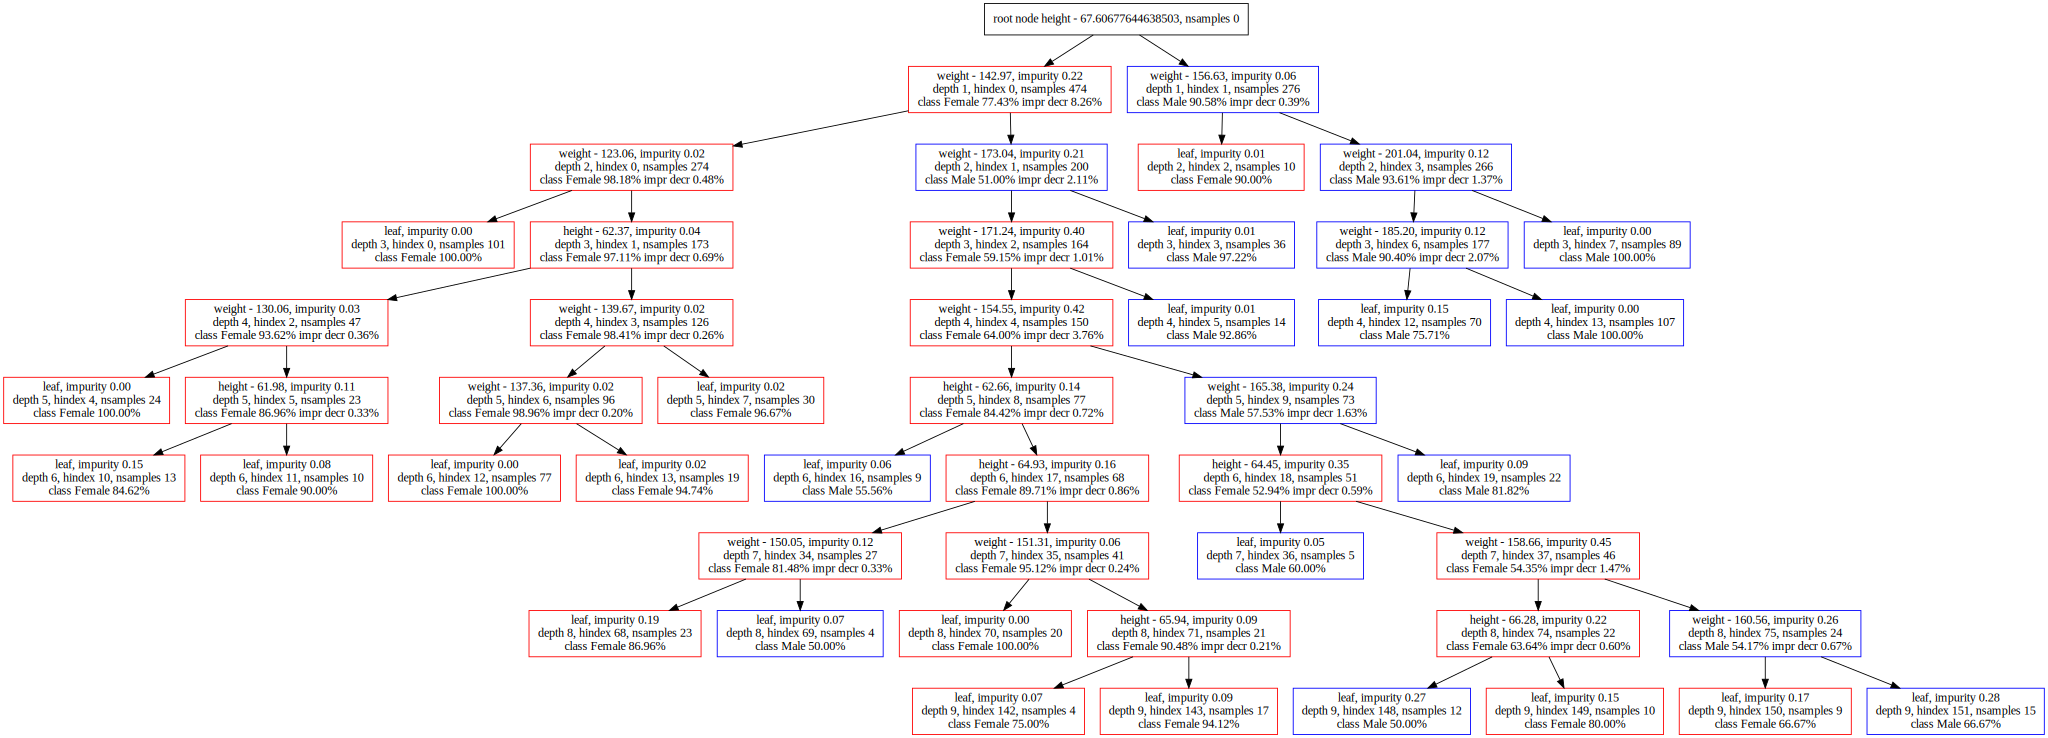

In [5]:
%%time
model = CustomDecisionTreeClassifier(max_depth=10, debug=False, criterion='gini', random_state=1, splitter='random', min_impurity_decrease=0.002, min_samples_split=10, min_samples_leaf=4)
model.fit(features_train.values, target_train.values)
test_model(model)
visualize_tree(model)

# RandomForestClassifier

In [6]:
from mlscratchnk.supervised.random_forest import RandomForestClassifier as CustomRandomForestClassifier

model = CustomRandomForestClassifier(n_estimators=20, max_features='max', max_depth=10, random_state=1, min_impurity_decrease=0.002, min_samples_split=7, min_samples_leaf=4)

model.fit(features_train.values, target_train.values)
test_model(model)

train score = 0.928, valid score f1 = 0.916, depth 10, name RandomForestClassifier


## LogisticRegression

0. Should we scale data before?
1. Calculate loss properly
2. Multiclass 
3. Tolerance for stopping

In [7]:
%%time
from logistic_regression import LogisticRegression as CustomLogisticRegression

model = CustomLogisticRegression(random_state=1, learning_rate=0.1, max_iters=1000, verbose=False)
model.fit(features_train.values, target_train.values)
test_model(model)
model.get_current_iterations()


train score = 0.931, valid score f1 = 0.934, depth None, name LogisticRegression
Wall time: 1.2 s


999

# GradientBoosting

In [10]:
model = GradientBoostingClassifier(n_estimators=10, max_depth=6, random_state=1, min_impurity_decrease=0.005, min_samples_split=10, min_samples_leaf=4)
model.fit(features_train.values, target_train.values)

test_model(model)

ValueError: operands could not be broadcast together with shapes (750,2) (750,) (750,2) 

## Compare with sklearn implementations

In [7]:
%%time

model = DecisionTreeClassifier(max_depth=None, splitter='random', random_state=1, min_impurity_decrease=0.005, min_samples_split=10, min_samples_leaf=4)
model.fit(features_train, target_train)

test_model(model)

model = RandomForestClassifier(n_estimators=10, max_depth=6, random_state=1, min_impurity_decrease=0.005, min_samples_split=10, min_samples_leaf=4)
model.fit(features_train, target_train)

test_model(model)

model = LogisticRegression(penalty='l2', C=1, max_iter=100, random_state=1)
model.fit(features_train, target_train)
test_model(model)

dummy_classifier = DummyClassifier(random_state=1)
dummy_classifier.fit(features_train, target_train)
print(f'dummy score {f1_score(target_valid, dummy_classifier.predict(features_valid)):0.3f}')

train score = 0.921, valid score f1 = 0.908, depth 4, name DecisionTreeClassifier
train score = 0.940, valid score f1 = 0.900, depth None, name RandomForestClassifier
train score = 0.937, valid score f1 = 0.923, depth None, name LogisticRegression
dummy score 0.504
Wall time: 129 ms


In [44]:
def calculate_variance(X):
    if len(X.shape) == 1:
        X = X.reshape((-1, 1))
    """ Return the variance of the features in dataset X """
    mean = np.full(shape=np.shape(X), fill_value=np.mean(X, axis=0))
    n_samples = np.shape(X)[0]
    variance = (1 / n_samples) * np.diag((X - mean).T.dot(X - mean))
    
    return variance

a = np.array([1, 2, 3, 4, 5, 0, 0, 0, 0])

calculate_variance(a)

array([3.33333333])